# Generación de música con modelo Transformer

**Proyecto del Diplomado de Inteligencia Artificial y Ciencia de Datos**

_Felipe Andres Castillo_

En este notebook se implementa un modelo de generación de melodías, usando una arquitectura _Decoder-only Transformer_. El modelo es entrenado con el [Maestro dataset](https://magenta.tensorflow.org/datasets/maestro). En el proceso se explora lo que es la _tokenización_ de archivos MIDI, el mecanismo de _atención global relativa_ (relative global attention) y el almacenamiento de memoria caché para mejorar los tiempos de inferencia.

Este trabajo está basado en el [noteboook de Keras](https://keras.io/examples/generative/midi_generation_with_transformer/) , que a su vez está basado en el artículo "Music Transformer", por Huang et al. (2018) ([paper](https://arxiv.org/abs/1809.04281) y
[codigo](https://github.com/jason9693/MusicTransformer-tensorflow2.0)).

## Setup

In [1]:
!pip install -qq midi_neural_processor
!pip install -qq keras_hub
!pip install -qq "keras>=3.6.0"  # Permite el uso de keras.utils.Config

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.3 MB/s eta 0:00:00


Para escuchar el audio de las pistas de entrenamiento, así como las generadas, se instalan ``fluidsynth`` y ``pyfluidsynth``. El primero es un software sintetizador que convierte archivos MIDI a audio (generalmente WAV) utilizando _soundfonts_. Un _SoundFont_ es un archivo que contiene muestras de audio grabadas de instrumentos musicales y las instrucciones sobre cómo reproducir esas muestras cuando se recibe un mensaje MIDI. Es como un banco de sonidos pregrabados que se utiliza para sintetizar música. Mientras que ``pyfluidsynth`` es un wrapper en Python para interactuar con ``fluidsynth``. Permite cargar archivos MIDI y renderizarlos como audio dentro de Python.

In [2]:
!sudo apt-get -qq install -y fluidsynth 2> /dev/null
!pip install -qq pyfluidsynth scipy

Selecting previously unselected package libqt5core5a:amd64.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../00-libqt5core5a_5.15.3+dfsg-2ubuntu0.2_amd64.deb ...
Unpacking libqt5core5a:amd64 (5.15.3+dfsg-2ubuntu0.2) ...
Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../01-libevdev2_1.12.1+dfsg-1_amd64.deb ...
Unpacking libevdev2:amd64 (1.12.1+dfsg-1) ...
Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../02-libmtdev1_1.1.6-1build4_amd64.deb ...
Unpacking libmtdev1:amd64 (1.1.6-1build4) ...
Selecting previously unselected package libgudev-1.0-0:amd64.
Preparing to unpack .../03-libgudev-1.0-0_1%3a237-2build1_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (1:237-2build1) ...
Selecting previously unselected package libwacom-common.
Preparing to unpack .../04-libwacom-common_2.2.0-1_all.deb ...
Unpacking libwacom-common (2.2.0-1) ...
Selecting previously unselected package libwacom9:a

In [3]:
import os           # Manipulación de archivos y directorios
import random       # Generación de números aleatorios
import tempfile     # Creación de archivos o carpetas temporales
import numpy as np
import keras
import midi_neural_processor.processor as midi_tokenizer
from keras import callbacks, layers, ops, optimizers, utils
from keras_hub import layers as hub_layers
from os import path
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Configuración

Se define la configuración del modelo y el dataset que se estará usando. En concreto, se especifica la estructura básica del vocabulario que el modelo usará y configura parámetros importantes para el entrenamiento del Transformer.

Se construye un rango de tokens válidos a partir de diferentes tipos de eventos MIDI. Cada uno de estos ``RANGE_*`` representa un conjunto específico de tokens que se utilizarán en la secuencia que se pasa al modelo. Cada grupo de tokens tiene un tamaño definido; por ejemplo ``RANGE_NOTE_ON`` incluye todas las notas posibles dentro del rango MIDI estándar (generalmente 0 a 127), por lo que constaría de 128 tokens. Luego ``event_range`` es un número que indica cuántos tokens diferentes puede manejar el modelo, el cual se calcula sumando la cantidad de tokens en las diferentes categorías de eventos MIDI.

También se define un diccionario de configuración (``CONFIG``) con parámetros esenciales para el modelo.

In [4]:
event_range = midi_tokenizer.RANGE_NOTE_ON        # tokens que representan eventos de inicio de nota
event_range += midi_tokenizer.RANGE_NOTE_OFF      # tokens que representan eventos de finalización de nota
event_range += midi_tokenizer.RANGE_TIME_SHIFT    # tokens que indican un avance en el tiempo (para modelar duraciones o pausas)
event_range += midi_tokenizer.RANGE_VEL           # tokens que representan la velocidad (o intensidad) con la que se toca cada nota

CONFIG = utils.Config(
    max_sequence_len=2048,                      # Longitud máxima de la secuencia de tokens que el modelo puede procesar de una sola vez
    embedding_dim=256,                          # Dimensión de los vectores de embedding utilizados para representar cada token
    num_transformer_blocks=6,                   # Número de bloques Transformer apilados en la arquitectura
    batch_size=6,                               # Número de ejemplos procesados simultáneamente durante el entrenamiento
    token_pad=event_range,                      # Token especial utilizado para padding (relleno); este se coloca inmediatamente después de los tokens definidos (event_range)
    token_start_of_sentence=event_range + 1,    # Token que indica el inicio de una secuencia
    token_end_of_sentence=event_range + 2,      # Token que indica el final de una secuencia
    vocabulary_size=event_range + 3,            # Tamaño total del vocabulario, que incluye todos los tokens MIDI más los tokens especiales (anteriores tres)
    model_out="/content/drive/MyDrive/Colab Notebooks/MIDI_music_transformer/music_transformer_v1.keras",    # Ruta donde se guardará el modelo entrenado
    seed=42,                                    # Semilla para garantizar reproducibilidad en el entrenamiento.
)

utils.set_random_seed(CONFIG.seed)

## MAESTRO dataset

El MAESTRO (MIDI and Audio Edited for Synchronous TRacks and Organization) es un dataset compuesto por aproximadamente 200 horas de interpretaciones de piano, recopiladas durante diez años de la International Piano-e-Competition. En total consta de 1276 interpretaciones, de compositores como Franz Schubert, Frédéric Chopin, Johann Sebastian Bach, Ludwig van Beethoven, Wolfgang Amadeus Mozart, entre otros.

### Descarga del dataset

Se descarga y extrae el conjunto de datos MIDI Maestro (versión 3.0.0)

In [5]:
def download_maestro(output_dir=None):
    """Download the Maestro MIDI dataset.
    Extracted from: https://magenta.tensorflow.org/datasets/maestro
    """
    # Si no se proporciona un directorio de salida (output_dir), la función usa tempfile.mkdtemp() para crear un directorio temporal.
    # Si se pasa un directorio específico, ese se utiliza como lugar de destino. Si el directorio no existe, se crea utilizando os.makedirs.
    output_dir = tempfile.mkdtemp() if output_dir is None else output_dir
    os.makedirs(output_dir, exist_ok=True)

    # Descargar y extraer el archivo ZIP
    dir = utils.get_file(
        origin="https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip",
        extract=True,
    )

    # Se recorre el directorio extraído (dir) utilizando os.walk
    # Para cada archivo encontrado, si el archivo termina con las extensiones .midi o .mid, se agrega al conjunto midi_files
    midi_files, file_paths = set(), list()
    for root, _, files in os.walk(dir):
        for file in files:
            if file.lower().endswith(".midi") or file.lower().endswith(".mid"):
                midi_files.add(path.join(root, file))

    # Se mueven los archivos MIDI al directorio de salida. Se almacena la nueva ruta en la lista file_paths
    for file in sorted(midi_files):
        file_paths.append(new_path := path.join(output_dir, path.basename(file)))
        os.rename(file, new_path)
    return file_paths


paths = list(sorted(download_maestro(output_dir="datasets/maestro")))
output_dir = path.dirname(paths[0])

58416533/58416533 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### División del dataset

Se divide el conjunto de datos en un conjunto de entrenamiento y validación

In [6]:
# Se genera una permutación aleatoria de índices de los archivos MIDI que están almacenados en la lista paths
indices = np.random.permutation(len(paths))
# El 10% de los datos serán para validación
split = int(len(paths) * 0.1)
train_paths = [paths[i] for i in indices[split:]]
val_paths = [paths[i] for i in indices[:split]]

### Escuchar un archivo MIDI

Se utilza la librería ``pretty_midi`` para convertir un archivo MIDI en un archivo de audio (archivo WAV).

In [7]:
def visualize_midi(midi_path, sampling_rate=16000, seconds=30, out_dir=None):
    """
    midi_path: Ruta al archivo MIDI que se desea convertir
    sampling_rate: Tasa de muestreo para el audio (por defecto, 16,000 Hz)
    seconds: Duración en segundos de la grabación a generar
    out_dir: Directorio donde se guardará el archivo WAV
    """
    import pretty_midi
    from scipy.io.wavfile import write as write_wav
    from IPython.display import Audio

    # Cración del archivo de audio
    pretty_midi_file = pretty_midi.PrettyMIDI(midi_path)
    waveform = pretty_midi_file.fluidsynth(fs=sampling_rate)[: seconds * sampling_rate]

    # Si no se proporciona un directorio de salida, la función devuelve un objeto Audio
    # que se puede usar para reproducir el audio directamente en el cuaderno de Jupyter
    if out_dir is None:
        # IPython display
        return Audio(waveform, rate=sampling_rate)

    # Si sí se proporciona un directorio, se crea (si no existe) y se guarda el archivo de audio
    os.makedirs(out_dir, exist_ok=True)
    audio_path = path.join(out_dir, path.basename(midi_path).split(".")[0] + ".wav")
    write_wav(audio_path, sampling_rate, (waveform * 32767).astype(np.int16))
    return audio_path

In [8]:
# Ejemplo: se guarda el archivo de audio
#print(visualize_midi(train_paths[0], out_dir="tmp/"))
# Ejemplo: se reproduce el audio desde el notebook
#visualize_midi(train_paths[0])

### MIDI tokenization


MIDI Tokenization es el proceso de convertir datos MIDI (Musical Instrument Digital Interface) en una secuencia de tokens que pueda ser procesada por un modelo de deep learning como un Transformer. Es esencialmente un método para transformar música en un formato comprensible para redes neuronales.

Un archivo MIDI no es audio propiamente dicho. Es un conjunto de instrucciones que indican:

- Qué notas tocar (C, D#, F, etc.)
- Cuándo tocarlas (inicio y duración)
- Velocidad o intensidad (qué tan fuerte se toca la nota)
- Instrumento utilizado (piano, guitarra, batería, etc.)
- Eventos de control (cambios de tempo, pedal, etc.)

Para convertir la información continua (tiempo, duración, velocidad) en valores discretos (tokens), se consideran diferentes tipos de tokens:
- Note-On Tokens: Indican cuándo empieza una nota.
- Note-Off Tokens: Indican cuándo termina una nota.
- Velocity Tokens: Indican la intensidad de la nota.
- Time Tokens: Indican pausas o avances en el tiempo.
- Instrument Tokens: Identifican qué instrumento se está usando.

Las siguientes funciones se encargan de preprocesar (en paralelo) los archivos MIDI convirtiendo cada archivo en una secuencia de tokens. Se utiliza la librería ``midi_neural_processor`` para realizar dicho proceso.

In [9]:
def encode_midi_task(midi_path):
    import midi_neural_processor.processor as midi_tokenizer
    return midi_tokenizer.encode_midi(midi_path)


def preprocess_midi_files(file_paths, save_dir=None):
    from multiprocessing import Pool, cpu_count

    save_dir = path.dirname(file_paths[0]) if save_dir is None else save_dir
    os.makedirs(save_dir, exist_ok=True)

    # Si el archivo notes.npz ya existe (es decir, ya se preprocesaron los archivos antes),
    # la función carga las notas desde ese archivo y las devuelve. Si no, se procede a procesar los archivos
    output_file = path.join(save_dir, "notes.npz")
    if path.exists(output_file):
        npz_file = np.load(output_file)
        return [npz_file[key] for key in npz_file.keys()]

    # Se procesan los archivos en paralelo
    progbar = utils.Progbar(len(file_paths), unit_name="MIDI_file", interval=5)
    pool = Pool(cpu_count() - 1)
    all_notes = []
    for notes in pool.imap_unordered(encode_midi_task, file_paths):
        progbar.add(1)
        all_notes.append(np.array(notes))

    # Una vez que se agregan las notas tokenizadas a la lista all_notes, se guardan en el archivo .npz
    np.savez(output_file, *all_notes)
    return all_notes

In [10]:
train_midis = preprocess_midi_files(train_paths, path.join(output_dir, "train"))
val_midis = preprocess_midi_files(val_paths, path.join(output_dir, "val"))

1149/1149 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/MIDI_file
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/MIDI_file


In [11]:
# Si ya se tienen los archivos descargados
# train_midis_npz = np.load("/content/notes_train.npz")
# train_midis = [train_midis_npz[key] for key in train_midis_npz]

# val_midis_npz = np.load("/content/notes_val.npz")
# val_midis = [val_midis_npz[key] for key in val_midis_npz]

### Dataset objects

Se crea una clase ``MidiDataset``, diseñada para cargar y preparar los archivos MIDI de manera eficiente para el entrenamiento. Se generan secuencias aleatorias de notas para cada batch, asegurando que todas las secuencias tengan la longitud correcta mediante truncamiento o padding.

In [12]:
class MidiDataset(utils.PyDataset):
    def __init__(
        self,
        encoded_midis,                              # Es la lista de archivos MIDI tokenizados
        batch_size=CONFIG.batch_size,
        max_sequence_len=CONFIG.max_sequence_len,
    ):
        super(MidiDataset, self).__init__()
        self.batch_size = batch_size
        self.max_sequence_len = max_sequence_len
        self.encoded_midis = encoded_midis
        batches, last_batch_size = divmod(len(encoded_midis), batch_size)   # Se calcula el número total de batches necesarios, utilizando divmod() para dividir
        self._num_batches = batches + int(last_batch_size > 0)              # la longitud de encoded_midis entre el batch_size. Si hay un resto, se añade un lote extra.

    # Este método devuelve el número total de batches que se generarán
    def __len__(self):
        return self._num_batches

    # Este método se llama para obtener un batch
    def __getitem__(self, idx):
        # Se selecciona aleatoriamente un batch de tamaño batch_size de secuencias MIDI
        batch = random.sample(self.encoded_midis, k=self.batch_size)
        # Se genera una secuencia de notas
        batch_data = [self._get_sequence(midi, self.max_sequence_len + 1) for midi in batch]
        # Conversión a array de Numpy
        batch_data = np.array(batch_data)
        # División de los datos en secuencias de entrada, y secuencias objetivo
        return batch_data[:, :-1], batch_data[:, 1:]

    # Este método se encarga de obtener una secuencia de notas aleatoria
    def _get_sequence(self, data, max_length):
        # Si la secuencia de notas (data) es mayor a max_length, se selecciona un segmento aleatorio,
        # pero si data es menor a max_length, se agrega el token end_of_sentence
        if len(data) > max_length:
            start = random.randrange(0, len(data) - max_length)
            data = data[start : start + max_length]
        elif len(data) < max_length:
            data = np.append(data, CONFIG.token_end_of_sentence)

        # Además, si data es menor a max_length, se hace padding con el token pad
        if len(data) < max_length:
            data = np.concatenate(
                (data, np.full(max_length - len(data), CONFIG.token_pad))
            )
        return np.asanyarray(data, dtype="int32")

In [13]:
train_dataset, val_dataset = MidiDataset(train_midis), MidiDataset(val_midis)

## Definición del modelo

### Arquitectura Decoder-only Transformer

El modelo transformer fue descrito por primera vez en un artículo de 2017 titulado "Attention is All You Need" de Ashish Vaswani, un equipo de Google Brain y un grupo de la Universidad de Toronto. Desde ese momento, estos modelo han pasado rápidamente a ser fundamentales en el procesamiento del lenguaje natural (PLN) y se han aplicado a una amplia gama de tareas de machine learning e inteligencia artificial.

La innovación clave del modelo transformer, que marca la diferencia respecto a los modelos de redes neuronales recurrentes (RNN) o redes neuronales convolucionales (CNN), es la introducción de dos conceptos: la codificación posicional y la autoatención.

- Codificación posicional (Positional encoding): introduce una representación de las posiciones que se suma a los embeddings de palabras o tokens. Hay varias formas de implementar esto, pero una de las más comunes es el uso de funciones sinusoidales de diferentes frecuencias. Básicamente, es un un vector que le dice al modelo en qué posición está cada palabra.

- Autoatención: la atención es un mecanismo que calcula el peso de cada palabra de una oración en relación con todas las demás palabras de la oración, por lo que el modelo puede predecir las palabras que probablemente se usarán en secuencia. Esta comprensión se aprende con el tiempo a medida que un modelo se entrena con una gran cantidad de datos. El mecanismo de autoatención permite que cada palabra preste atención a todas las demás palabras de la secuencia en paralelo, sopesando su importancia para el token actual.

#### El mecánismo Self-Attention

Self-attention funciona transformando el embedding inicial de cada palabra en función de sus interacciones con todas las demás palabras en la secuencia. Esta transformación involucra tres componentes:

- Query Matrix (WQ): el embedding de cada palabra es multiplicado por esta matriz (de pesos) para obtener un query vector **Q**; este representa una consulta que se hace sobre la secuencia para identificar relaciones importantes (_¿Qué tokens son relevantes para este token actual?_)

- Key Matrix (WK): simultaneamente, cada embedding se multiplica por esta matriz para obtener un key vector **K**; representa un identificador único para cada token, que puede ser comparado con las consultas (Q) para medir relevancia.

- Value Matrix (WV): de igual forma, de esta matriz de pesos se obtiene un vector **V**, el cual que representa la información que se pasará a otras palabras en función de su relevancia.

#### Correlaciones y enmascaramiento

Para medir la relevancia de cada token con respecto a otro, el modelo calcula el producto escalar de cada vector de consulta (Q) con cada vector clave (K) (attention score). Esto genera una cuadrícula de puntuaciones que representa la correlación entre cada par de palabras. Las puntuaciones más altas indican una mayor relevancia.

$$\text{Attention Score} = QK^{T}$$

Sin embargo, en los transformers que solo utilizan decodificadores, se quiere evitar que las palabras futuras influyan en la interpretación de las palabras anteriores, o de manera general, que el modelo no vea futuros tokens durante la generación de secuencias. Para ello se aplica _enmascaramiento_: las puntuaciones de las palabras futuras se establecen en menos infinito, lo que las pone a cero tras una normalización softmax.

$$\text{Attention Weights} = softmax\left(\frac{QK^T}{\sqrt{d_k}} \right) = softmax(\text{Masked Scores})$$
donde $d_k$ es la dimensión del espacio del embedding.

Una vez calculadas y enmascaradas las puntuaciones de atención, entra en juego los vectores de valores V. Para cada palabra, se calcula una suma ponderada de los vectores de valores de todas las demás palabras, donde las ponderaciones son las puntuaciones de atención normalizadas. En otras palabras:
$$ \text{Output} = \text{Attention Weights} \times  V$$
En esencia, esto permite que las palabras relevantes transmitan su información a la palabra que se está procesando.

El paso final del bloque self-attention consiste en sumar el output anterior al original embedding de la palabra. Este embedding actualizado ahora incorpora información contextual, reflejando el significado de la palabra dentro de la oración.

#### Multi-Head Attention


Si bien el self-attention es potente, puede verse limitada por su dependencia de un único conjunto de matrices de consulta (K y V). El multi-head attention soluciona esta limitación ejecutando múltiples operaciones de autoatención en paralelo, cada una con su propio conjunto de matrices. Esto permite al modelo capturar diferentes aspectos del contexto simultáneamente, para después combinar los resultados y producir un mejor embedding.

#### Construcción de un Decoder-only Transformer

Un transformer solo con decodificador se construye apilando múltiples capas, cada una de las cuales comprende dos componentes principales:
- Masked Self-Attention: como se explico, esta capa permite que los tokens incorporen información contextual de tokens anteriores.
- Perceptrones multicapa (MLP): los MLP son esencialmente redes neuronales de propagación hacia adelante que procesan cada embedding de forma independiente. Pueden considerarse como los "bancos de conocimiento" del transformer, que incorporan el conocimiento general adquirido durante el entrenamiento para refinar aún más los embeddings.

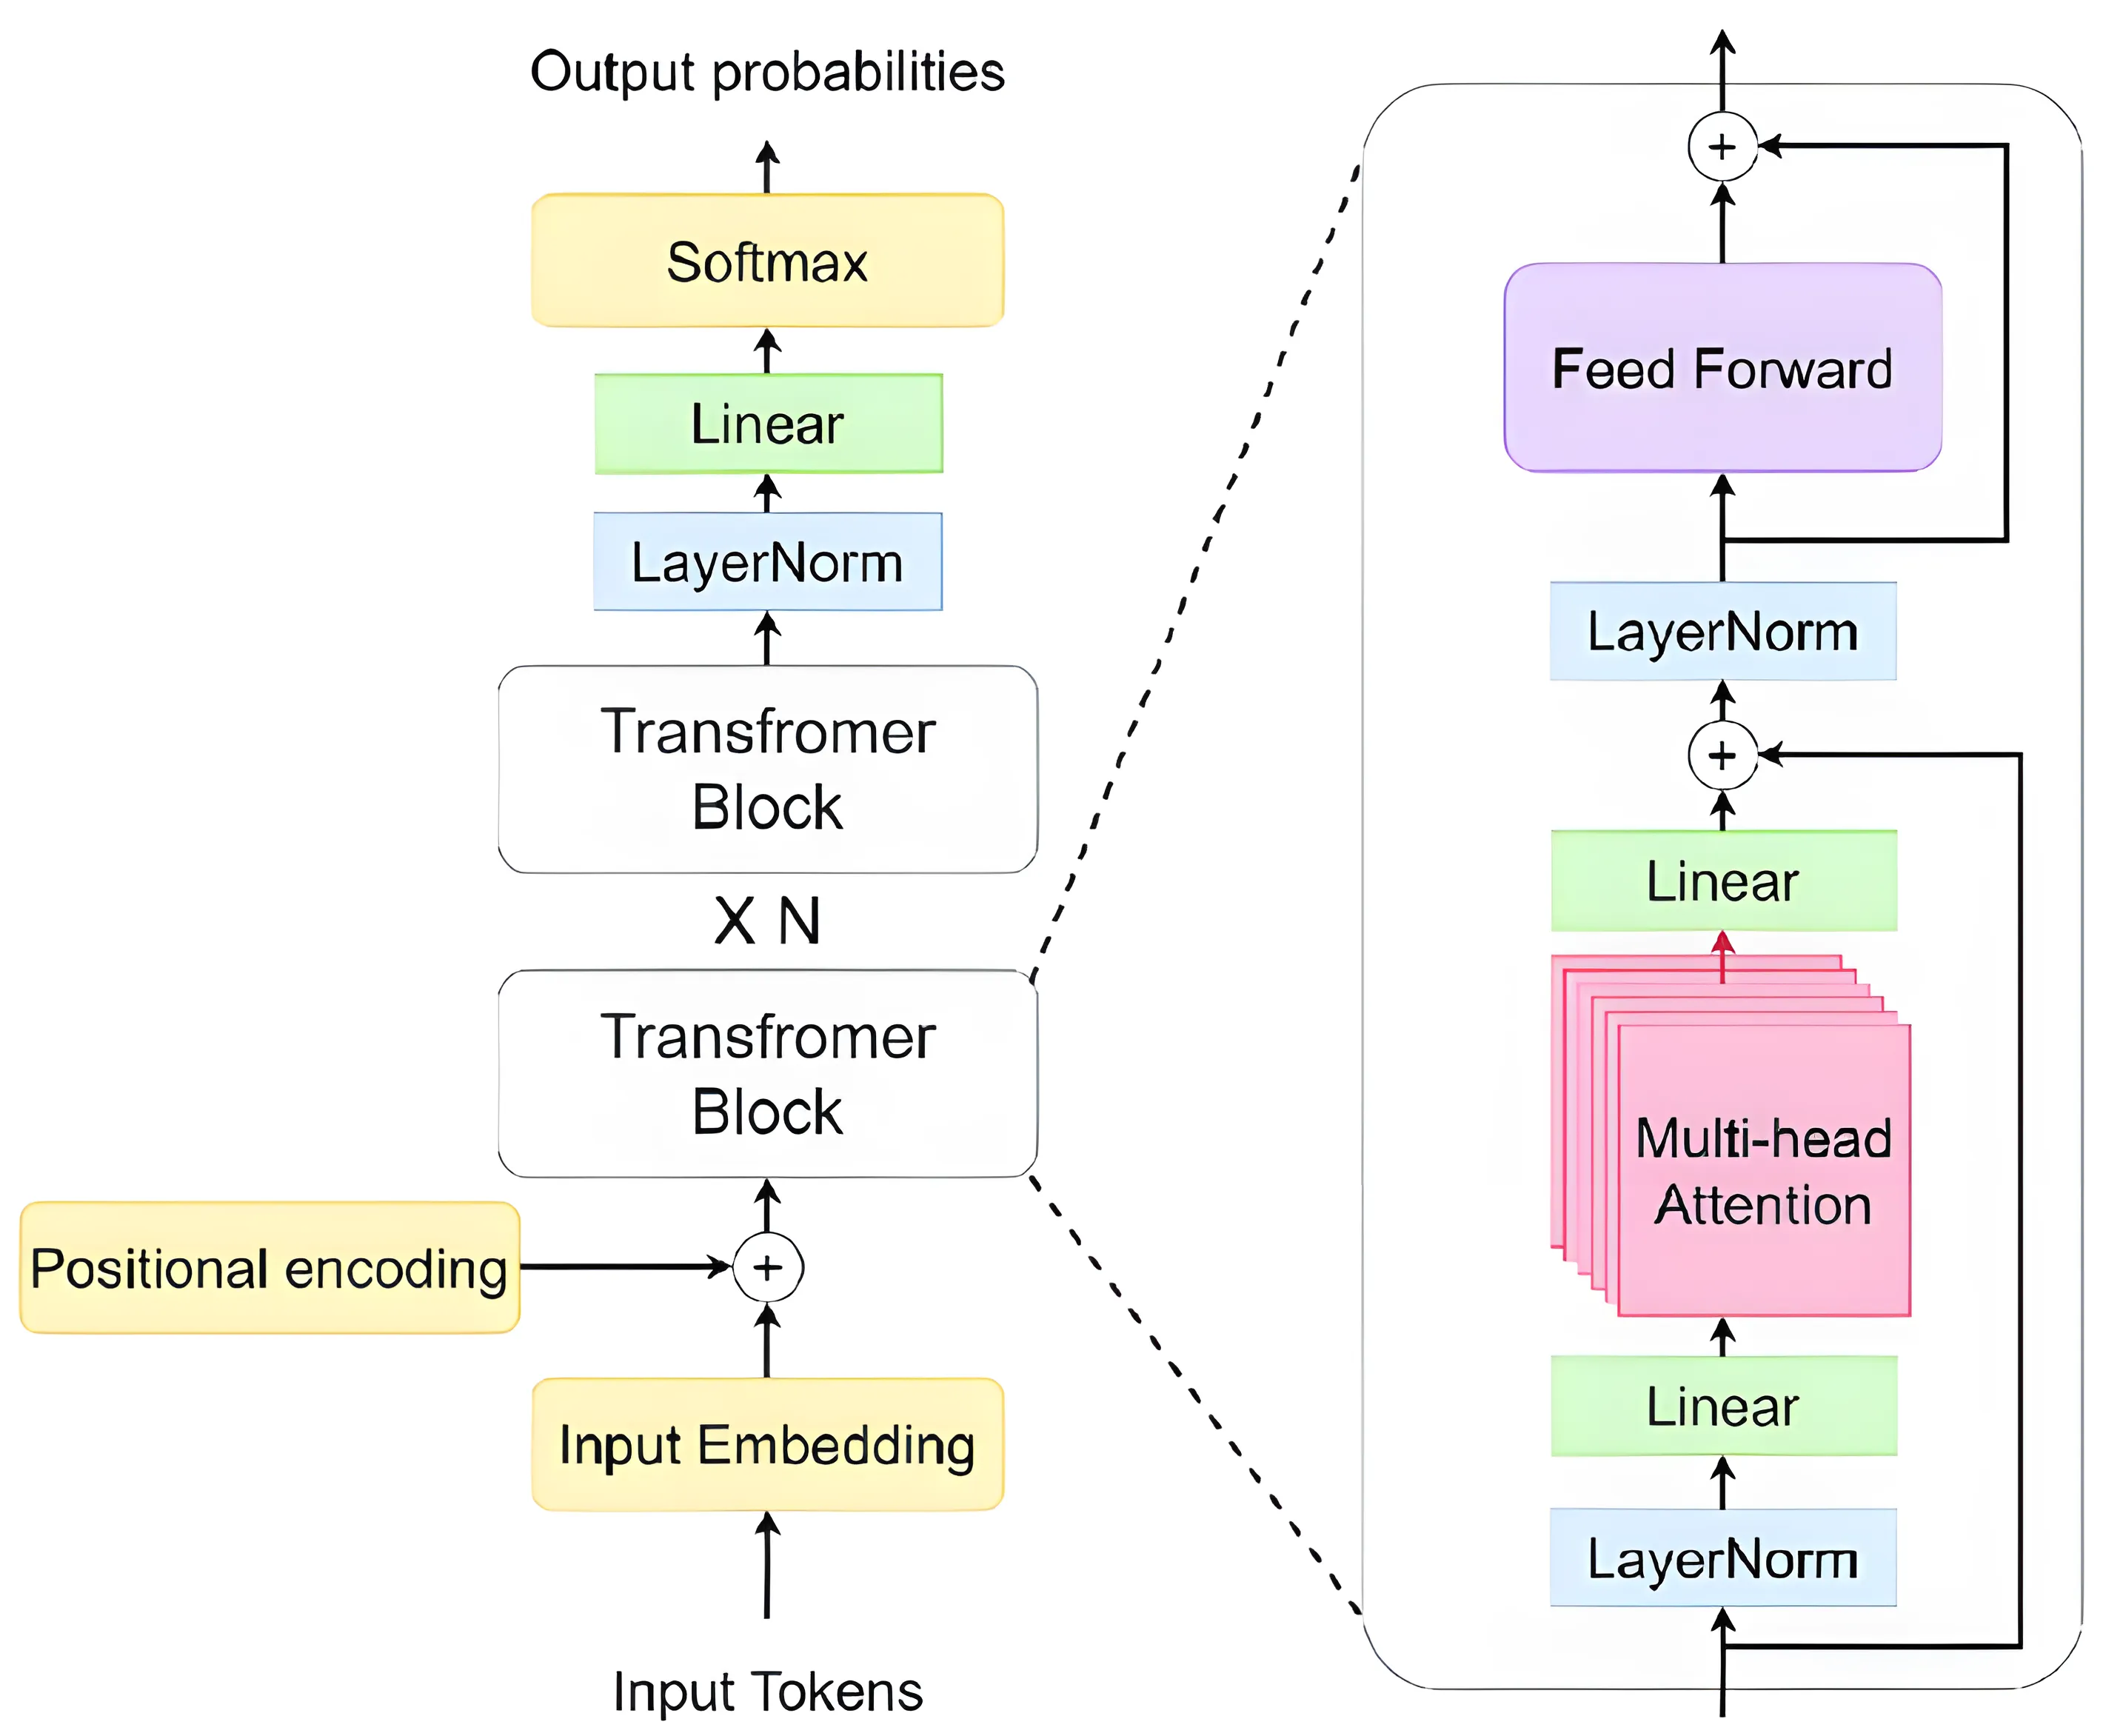

En este caso, para construir el módelo, se definen cuatro clases, las cuales se relacionan siguiendo una estructura jerarquica:
$$GlobalRelativeAttention ⇒ DecoderLayer ⇒ Decoder ⇒ MusicTransformerDecoder$$

### Relative Global Attention

se define una capa de atención personalizada, llamada ``Relative Global Attention``. Es una variante mejorada de la Self-Attention estándar utilizada en Transformers, especialmente adaptada para capturar relaciones relativas entre tokens en secuencias largas. Este mecanismo incorpora información posicional relativa en lugar de información posicional absoluta, lo que significa que se enfoca en la distancia entre tokens y no en su posición fija en la secuencia.

En el contexto de la composición de la musica, esta capa no se enfoca en la posición exacta de las notas, sino en la distancia entre ellas. Es decir, en vez de aprender que "la nota en la posición 10 es importante", aprende que "la nota que está 3 posiciones atrás es importante".

Cuando se toca una melodía repetitiva (como un ritmo o un patrón armónico), el modelo necesita recordar que algo ocurrió hace un rato, no necesariamente en una posición específica. Este tipo de atención permite que el modelo entienda relaciones relativas, como "la nota que se tocó hace 4 notas es importante" sin importar en qué parte de la melodía se esté.

In [14]:
@keras.utils.register_keras_serializable()
class RelativeGlobalAttention(layers.Layer):
    def __init__(self, num_heads, embedding_dim, max_sequence_len, **kwargs):
        super().__init__(**kwargs)
        # Se inicializan atributos
        # Algunos atributos se definen con None para evitar errores si en algún
        # lugar del código se accede a él antes de que se haya definido. En build se
        # hace explicitamente la inicialización en función del input_shape
        self.query_length = None
        self.key_length = None
        self.max_sequence_len = max_sequence_len
        self.relative_embedding = None
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.head_dim = embedding_dim // num_heads
        # Se inicializan layers
        self.query_dense = layers.Dense(int(self.embedding_dim))
        self.key_dense = layers.Dense(int(self.embedding_dim))
        self.value_dense = layers.Dense(int(self.embedding_dim))
        self.output_dense = layers.Dense(embedding_dim, name="output")

    def build(self, input_shape):
        self.query_length = input_shape[0][1]
        self.key_length = input_shape[1][1]
        # Matriz de relative embeddings
        # Cada fila representa un desplazamiento relativo.
        # Se utiliza para representar la relación entre la posición del token actual y otros tokens en la secuencia.
        self.relative_embedding = self.add_weight(
            (self.max_sequence_len, int(self.head_dim)), name="relative_embedding"
        )

    def _apply_dense_layer_and_split_heads(self, inputs, dense_layer):
        # Aplica la proyección lineal, pues la capa no tiene activación
        inputs = dense_layer(inputs)
        # División del espacio del embeddingen en multi-head attention
        # (batch_size, seq_len, embedding_dim) ->(batch_size, seq_len, num_heads, head_dim)
        new_shape = ops.shape(inputs)
        reshaped = ops.reshape(inputs, (new_shape[0], new_shape[1], self.num_heads, -1))
        # Se reordenan las dimensiones para que sea más fácil hacer el producto escalar Q*K^T
        return ops.transpose(reshaped, (0, 2, 1, 3)) # -> (batch_size, num_heads, sequence_length, head_dim)

    def call(self, inputs, mask=None, use_cache=False, past_key_value=None):
        # Cálculo de Q (inputs[0] -> (batch_size, seq_len, embedding_dim)), K (inputs[1]), V (inputs[2]) proyectados
        query = self._apply_dense_layer_and_split_heads(inputs[0], self.query_dense)
        key = self._apply_dense_layer_and_split_heads(inputs[1], self.key_dense)
        value = self._apply_dense_layer_and_split_heads(inputs[2], self.value_dense)

        # Si se usa caché, los valores de K y V se concatenan
        if use_cache:
            # Primer paso: sin caché previo
            if past_key_value is None:
                present_key_value = (key, value)
            else:
                # Ya hay caché: se expande
                past_key, past_value = past_key_value
                key = ops.concatenate([past_key, key], axis=2)
                value = ops.concatenate([past_value, value], axis=2)
                present_key_value = (key, value)

        # Cálculo de Q*K^T (scaled dot-product attention scores)
        # Dimensión: (batch_size, num_heads, query_len, key_len)
        attention_scores = ops.matmul(query, ops.transpose(key, [0, 1, 3, 2]))

        # Actualizar dinámicamente los tamaños actuales
        self.query_length = ops.shape(query)[2]
        self.key_length = ops.shape(key)[2]

        # Recorta la matriz de embedding relativos para que coincida con la dimensión de key y query, y se puedan sumar con attention scores
        # Dimensiones (max_seq_length, head_dim) -> (query_lenght, head_dim)
        start_idx = max(0, self.max_sequence_len - self.query_length)
        relative_embedding = self.relative_embedding[start_idx:, :]

        # Incorporación de relative attention scores (contribuciones de posición relativa a los attention scores)
        # Dimensión de relative attn scores: (batch_size, num_heads, query_len, query_len)
        attention_scores += self._compute_attention_scores(query, relative_embedding)
        # Normalización (se divide por √d_k)
        logits = attention_scores / ops.sqrt(self.head_dim)

        # Aplicación de la mascara
        if mask is not None:
            logits += ops.cast(mask, "float32") * -1e9

        # Cálculo attention weights
        attention_weights = ops.nn.softmax(logits, axis=-1) # Softmax sobre key_len
        attention_output = ops.matmul(attention_weights, value)
        # Dimensión de attn_output: (batch_size, num_heads, query_len, head_dim)

        # Fusionar attention heads y se aplica una ultima transformación lineal
        merged_attention = ops.transpose(attention_output, (0, 2, 1, 3)) # -> (batch_size, query_len, num_heads, head_dim)
        merged_attention = ops.reshape(
            merged_attention, (ops.shape(merged_attention)[0], -1, self.embedding_dim)
        ) # -> (batch_size, query_len, embedding_dim)
        output = self.output_dense(merged_attention)

        if use_cache:
          return output, attention_weights, present_key_value

        return output, attention_weights

    def _compute_attention_scores(self, query, relative_embedding):
        # Calculo de los relative attention scores usando positional encodings
        # Devuelve una matriz adicional de scores basada en la posición relativa entre los tokens, que se suma a los attention scores normales.
        # Esto le permite al modelo capturar relaciones entre tokens dependiendo de su distancia, no solo de su contenido.
        relative_scores = ops.einsum("bhld, md->bhlm", query, relative_embedding)
        relative_scores = self._apply_mask_to_relative_scores(relative_scores)
        return self._skew_attention_scores(relative_scores)

    def _apply_mask_to_relative_scores(self, scores):
        # Se aplica el enmascaramiento a los relative positional scores para ignorar los tokens futuros
        mask = ops.flip(
            ops.tri(scores.shape[-2], scores.shape[-1], dtype="float32"), axis=1
        )
        return mask * scores

    def _skew_attention_scores(self, scores):
        # Hace que se alinien los scores relativos correctamente con la secuencia
        padded_scores = ops.pad(scores, ((0, 0), (0, 0), (0, 0), (1, 0)))
        padded_shape = ops.shape(padded_scores)
        reshaped_scores = ops.reshape(
            padded_scores, (-1, padded_shape[1], padded_shape[-1], padded_shape[-2])
        )
        skewed_scores = reshaped_scores[:, :, 1:, :]

        if self.key_length > self.query_length:
            size_diff = self.key_length - self.query_length
            return ops.pad(skewed_scores, [[0, 0], [0, 0], [0, 0], [0, size_diff]])
        else:
            return skewed_scores[:, :, :, : self.key_length]

### Decoder Layer

Usando el ``RelativeGlobalAttention`` layer, podemos definir el ``DecoderLayer``, un bloque básico del decodificador Transformer.

Se encargará de procesar secuencias de tokens y mejorar su representación a través de atención y transformaciones no lineales. La función principal es aprender relaciones complejas entre tokens musicales y producir representaciones enriquecidas que capturen patrones musicales útiles para la generación de música.

In [15]:
@keras.utils.register_keras_serializable()
class DecoderLayer(layers.Layer):
    def __init__(self, embedding_dim, num_heads, max_sequence_len, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Se inicializan atributos
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.max_sequence_len = max_sequence_len

        # Se inicializan layers
        self.relative_global_attention_1 = RelativeGlobalAttention(
            num_heads, embedding_dim, max_sequence_len
        )

        self.feed_forward_network_pre = layers.Dense(self.embedding_dim // 2, "relu")
        self.feed_forward_network_pos = layers.Dense(self.embedding_dim)

        self.layer_normalization_1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_normalization_2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout_1 = layers.Dropout(dropout)
        self.dropout_2 = layers.Dropout(dropout)

    def call(self, inputs, mask=None, training=False, use_cache=False, past_key_value=None):
        # Bloque de atención
        # inputs es la secuencia completa (o el token) en su representación embedding + positional_encoding
        # inputs -> (batch_size, seq_len, embedding_dim), (inputs, inouts, inputs) -> (query, key, value)
        if use_cache:
            attention_out, attention_weights, present_key_value = self.relative_global_attention_1(
                (inputs, inputs, inputs), mask=mask, use_cache=True, past_key_value=past_key_value
            )
        else:
            attention_out, attention_weights = self.relative_global_attention_1(
                (inputs, inputs, inputs), mask=mask
            )
            present_key_value = None

        attention_out = self.dropout_1(attention_out, training=training)
        attention_out_normalized = self.layer_normalization_1(attention_out + inputs)

        ffn_out = self.feed_forward_network_pre(attention_out_normalized) # attention_out_normalized ?
        ffn_out = self.feed_forward_network_pos(ffn_out)
        ffn_out = self.dropout_2(ffn_out, training=training)
        out = self.layer_normalization_2(attention_out_normalized + ffn_out)

        return out, attention_weights, present_key_value

### Decoder

El ``Decoder`` es la arquitectura completa de decodificación que está compuesta por múltiples bloques individuales ``DecoderLayer``. Este decoder es responsable de procesar secuencias de tokens musicales y producir representaciones avanzadas que puedan usarse para generar nuevas secuencias musicales.

In [16]:
@keras.utils.register_keras_serializable()
class Decoder(layers.Layer):
    def __init__(self, embedding_dim, vocabulary_size, max_sequence_len, num_blocks, dropout):
        super(Decoder, self).__init__()
        # Se inicializan atributos
        self.embedding_dim = embedding_dim
        self.num_blocks = num_blocks
        # Se inicializan layers
        self.embedding = layers.Embedding(vocabulary_size, self.embedding_dim)
        self.positional_encoding = hub_layers.SinePositionEncoding()
        # Multiples decode layers
        self.decode_layers = [
            DecoderLayer(embedding_dim, embedding_dim // 64, max_sequence_len, dropout=dropout)
            for _ in range(num_blocks)
        ]
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs, mask=None, training=False, return_attention_weights=False, use_cache=False, past_key_values=None):

        # Añadiendo embedding y position encoding
        x = self.embedding(inputs)
        # Escalado de embeddings; importante para estabilizar los gradientes
        x = x * ops.sqrt(ops.cast(self.embedding_dim, "float32"))
        # Dado que position encoding sí depende de la posición del token en la secuencia, en este caso inputs sólo es un token
        # (a excepción del primer paso) por lo que hay que pasar explicitamente su posición
        if use_cache:
            # En el primer paso, past_key_values[i] será None, así que calculamos la posición a partir de la longitud de entrada
            if past_key_values[0] is None:
                position = inputs.shape[1]
            else:
                position = past_key_values[0][0].shape[2]
            x = x + self.positional_encoding(x, start_index=position)
        else:
            # x contiene toda la secuencia, así que la posición se puede inferir internamente
            x = x + self.positional_encoding(x)
        x = self.dropout(x, training=training)
        # El tensor x tiene dimensiones (batch_size, sequence_length, embedding_dim)

        weights = []
        presents = []

        for i in range(self.num_blocks):
            if use_cache:
                past = past_key_values[i]
            else:
                past = None
            x, attn_weights, present = self.decode_layers[i](
                x, mask=mask, training=training, use_cache=use_cache, past_key_value=past
            )
            weights.append(attn_weights)
            presents.append(present)

        if return_attention_weights:
            return x, weights, presents
        return x, presents

### Music Transformer Decoder

El ``MusicTransformerDecoder`` es el modelo completo basado en la arquitectura Transformer que se utiliza para generar secuencias musicales. Combina un ``Decoder`` (compuesto por múltiples ``DecoderLayer``) con una capa densa que actúa como la capa de salida para predecir tokens musicales.

Como parte del método de generación de secuencias, se utiliza el **Top-K Sampling**.

Cuando un modelo genera un nuevo token, lo hace basado en una distribución de probabilidad sobre todo el vocabulario posible. En lugar de simplemente escoger el token con mayor probabilidad (greedy decoding), Top-K Sampling se enfoca en una selección más diversa.

La forma en la que funciona es la siguiente:
1. Primero se genera la distribución de probabilidad; es decir, el modelo predice un conjunto de probabilidades sobre todos los tokens posibles.
2. Se ordenan los token de acuerdo a su probabilidad, de mayor a menor.
3. Se seleccionan los K tokens más probables
4. Lueo se normalizan las probabilidades de estos K tokens para que sumen 1
5. Y se selecciona al azar uno de estos K tokens

Como resultado, este metodo genera música más diversa, con un menor riesgo de incoherencias extremas al no permitir que tokens con probabilidades bajas sean seleccionados.

In [17]:
@keras.utils.register_keras_serializable()
class MusicTransformerDecoder(keras.Model):
    def __init__(
        self,
        embedding_dim=CONFIG.embedding_dim,
        vocabulary_size=CONFIG.vocabulary_size,
        num_blocks=CONFIG.num_transformer_blocks,
        max_sequence_len=CONFIG.max_sequence_len,
        dropout=0.2,
    ):
        # Se inicializan atributos
        super(MusicTransformerDecoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocabulary_size = vocabulary_size
        self.num_blocks = num_blocks
        self.max_sequence_len = max_sequence_len

        # Se inicializan layers
        # Transformer decoder
        self.decoder = Decoder(
            embedding_dim, vocabulary_size, max_sequence_len, num_blocks, dropout
        )
        # Output layer
        self.fc = layers.Dense(self.vocabulary_size, activation=None, name="output")

    @staticmethod
    def get_look_ahead_mask(max_sequence_len, inputs):
        sequence_length = min(max_sequence_len, inputs.shape[1])
        sequence_mask = ops.logical_not(
            ops.tri(sequence_length, sequence_length, dtype="bool")
        )

        inputs = ops.cast(inputs[:, None, None, :], "int32")
        output_pad_tensor = ops.ones_like(inputs) * CONFIG.token_pad
        decoder_output_mask = ops.equal(inputs, output_pad_tensor)
        return ops.cast(ops.logical_or(decoder_output_mask, sequence_mask), "int32")

    def call(self, inputs, training=False, use_cache=False, past_key_values=None):
        mask = self.get_look_ahead_mask(self.max_sequence_len, inputs)
        # if use_cache:
        #     if past_key_values == [None] * self.num_blocks:
        #         # Primer paso: usar máscara
        #         mask = self.get_look_ahead_mask(self.max_sequence_len, inputs)
        #     else:
        #         # Siguientes pasos: no aplicar máscara
        #         mask = None
        # else:
        #     mask = self.get_look_ahead_mask(self.max_sequence_len, inputs)

        x, present_key_values = self.decoder(
            inputs,
            mask=mask,
            training=training,
            use_cache=use_cache,
            past_key_values=past_key_values,
        )
        logits = self.fc(x)
        if use_cache:
            return logits, present_key_values  # Para generación paso a paso
        return logits  # Para entrenamiento

    # --- Metodos de generación de secuencia

    def generate(self, inputs: list, length=CONFIG.max_sequence_len, top_k=5, use_cache=False):

        # Se convierte los tokens de entrada/semilla en un tensor
        inputs = ops.convert_to_tensor([inputs])
        # Se determina el número de tokens a predecir/generar
        added_tokens = min(length, self.max_sequence_len - inputs.shape[1])
        # Se inicializa una barra de progreso para mostrar cuántos tokens se han generado
        progbar = utils.Progbar(added_tokens, unit_name="token", interval=5)
        # Relleno de la secuencia de entrada con padding
        out = ops.pad(inputs, ((0, 0), (0, added_tokens)), "constant", CONFIG.token_pad)
        seed_len = inputs.shape[1]

        if use_cache:
            past_key_values = [None] * self.num_blocks
            # Paso inicial: obtener logits del seed completo
            logits, past_key_values = self.call(out[:, :seed_len],
                                                training=False,
                                                use_cache=True,
                                                past_key_values=past_key_values,
                                                )
            # Genera el primer token
            distribution = ops.stop_gradient(logits[0, -1])
            top_k_distribution, top_k_indices = ops.top_k(distribution, k=top_k)
            new_token_idx = keras.random.categorical(top_k_distribution[None, :], 1)
            token_id = ops.take(top_k_indices, new_token_idx[0])
            token = ops.cast(token_id, out.dtype)
            out = ops.scatter_update(out, ((0, seed_len),), token)
            progbar.add(1)
            seed_len += 1

        # Generación de tokens por medio de top-k sampling
        for token_idx in range(seed_len - 1, seed_len - 1 + added_tokens):
            # Llama al modelo completo
            if use_cache:
                logits, past_key_values = self.call(out[:, token_idx:token_idx + 1], training=False, use_cache=True, past_key_values=past_key_values)
            else:
                logits = self.call(out[:, :token_idx + 1], training=False, use_cache=False, past_key_values=None)

            #Selecciona el vector del último token
            distribution = ops.stop_gradient(logits[0, -1])
            # Se seleccionan los top-k tokens y sus probabilidades
            top_k_distribution, top_k_indices = ops.top_k(distribution, k=top_k)
            # Se realiza un muestreo estocástico entre esos k tokens usando su distribución
            new_token_idx = keras.random.categorical(top_k_distribution[None, :], 1)
            # Transforma ese índice relativo en el token real del vocabulario, y lo devuelve
            token_id = ops.take(top_k_indices, new_token_idx[0])
            # Se calcula el nuevo token y se formatea al tipo de dato de out
            token = ops.cast(token_id, out.dtype)
            # Inserta el nuevo token generado en la secuencia out, justo en la siguiente posición
            out = ops.scatter_update(out, ((0, token_idx + 1),), token)
            progbar.add(1)

        return ops.convert_to_numpy(out[0])

    # --- Serialization methods

    def get_config(self):
        atts = ["embedding_dim", "vocabulary_size", "num_blocks", "max_sequence_len"]
        return {a: getattr(self, a) for a in atts}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Entrenamiento del modelo

### Función de perdida

Se define una función de perdida personalizada para entrenar al modelo. Calcula el categorical cross-entropy loss

In [18]:
@keras.utils.register_keras_serializable()
def train_loss(y_true, y_pred):
    # Ignora los tokens que corresponden a padding
    mask = ops.cast(ops.logical_not(ops.equal(y_true, CONFIG.token_pad)), "float32")
    # Convierte las etiquetas (y_true) en un formato one-hot para usarlas con la función de pérdida
    y_true = ops.one_hot(ops.cast(y_true, "int32"), CONFIG.vocabulary_size)
    return ops.categorical_crossentropy(y_true, y_pred, from_logits=True) * mask

### Learning rate schedule

En arquitecturas Transformer, una tasa de aprendizaje constante puede dificultar la convergencia. Este scheduler ajusta dinámicamente la tasa de aprendizaje durante el entrenamiento, siguiendo un patrón específico que ayuda al modelo a aprender de manera más efectiva.

In [19]:
@keras.utils.register_keras_serializable()
class CustomSchedule(optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.embedding_dim = embedding_dim
        self.warmup_steps = warmup_steps

        self._embedding_dim = ops.cast(self.embedding_dim, "float32")
        # Numerical stability adjustment on torch, which is less precise
        self._lr_adjust = 0.1 if keras.backend.backend() == "torch" else 1.0

    def get_config(self):
        return {"embedding_dim": self.embedding_dim, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        step_rsqrt = ops.rsqrt(ops.cast(step, "float32"))
        warmup_adjust = step * (self.warmup_steps**-1.5)
        output = ops.rsqrt(self._embedding_dim) * ops.minimum(step_rsqrt, warmup_adjust)
        return self._lr_adjust * output

### Entrenamiento

Se define una función de entrenamiento, en la cual se configura el optmizador (en este caso, Adam) y su learning rate, dado por la clase definida anteriormente. También se compila el modelo y se configura el callback para guardar automáticamente el mejor modelo cuando se obtenga el mejor resultado de validación.

In [20]:
def train_model(model, train_ds, val_ds, epochs=20):
    # Configurar optimizador
    learning_rate = CustomSchedule(CONFIG.embedding_dim)
    optimizer = optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Se compila el modelo
    model.compile(optimizer=optimizer, loss=train_loss)

    # Se entrena el modelo
    save_cb = callbacks.ModelCheckpoint(CONFIG.model_out, save_best_only=True)
    model.fit(
        train_ds, validation_data=val_ds, epochs=epochs, callbacks=[save_cb], verbose=2
    )
    return model

In [21]:
model = train_model(MusicTransformerDecoder(), train_dataset, val_dataset, epochs=10)

Epoch 1/10
192/192 - 75s - 392ms/step - loss: 5.5991 - val_loss: 5.0148
Epoch 2/10
192/192 - 12s - 63ms/step - loss: 4.9546 - val_loss: 4.7115
Epoch 3/10
192/192 - 12s - 63ms/step - loss: 4.2822 - val_loss: 4.0812
Epoch 4/10
192/192 - 12s - 63ms/step - loss: 4.0502 - val_loss: 3.9437
Epoch 5/10
192/192 - 12s - 63ms/step - loss: 3.9340 - val_loss: 3.8653
Epoch 6/10
192/192 - 12s - 63ms/step - loss: 3.8356 - val_loss: 3.7061
Epoch 7/10
192/192 - 12s - 63ms/step - loss: 3.7155 - val_loss: 3.6396
Epoch 8/10
192/192 - 12s - 63ms/step - loss: 3.5886 - val_loss: 3.3935
Epoch 9/10
192/192 - 12s - 63ms/step - loss: 3.3231 - val_loss: 3.2312
Epoch 10/10
192/192 - 12s - 63ms/step - loss: 3.2014 - val_loss: 3.1287


In [22]:
# if path.exists(CONFIG.model_out):
#     model = keras.models.load_model(CONFIG.model_out)
    # Seguir entrenando a partir del checkpoint
    # train_model(model, train_dataset, val_dataset, epochs=20)
# else:
#     # Train the model
#     model = train_model(MusicTransformerDecoder(), train_dataset, val_dataset, epochs=20)

## Generación de música

In [23]:
def generate_music(model, seed_path, length=1024, out_dir=None, top_k=None, use_cache=False):
    # Se comprueba si existe el directorio
    out_dir = out_dir if out_dir is not None else tempfile.mkdtemp()
    os.makedirs(out_dir, exist_ok=True)

    # Se obtienen los tokens que sirven como semilla para generar la nueva melodía
    inputs = midi_tokenizer.encode_midi(seed_path)[0:100]

    # Generación de la música
    result = model.generate(inputs, length=length, top_k=top_k, use_cache=False)

    # Se guarda el archivo
    output_path = path.join(out_dir, path.basename(seed_path).split(".")[0] + ".mid")
    midi_tokenizer.decode_midi(result, output_path)
    return output_path

### Ejemplo 1

In [24]:
# Canción original; uno de los archivos MIDI del MAESTRO dataset
visualize_midi(val_paths[-1])

In [25]:
# Canción generada (inferencia sin caché)
output_file = generate_music(model, val_paths[-1], 1024, out_dir="tmp/", top_k=15, use_cache=False)
visualize_midi(output_file, seconds = 120)

1024/1024 ━━━━━━━━━━━━━━━━━━━━ 151s 145ms/token
info removed pitch: 58
info removed pitch: 39
info removed pitch: 42
info removed pitch: 54
info removed pitch: 59
info removed pitch: 66
info removed pitch: 87
info removed pitch: 80
info removed pitch: 87
info removed pitch: 87
info removed pitch: 82
info removed pitch: 99
info removed pitch: 79
info removed pitch: 79
info removed pitch: 79
info removed pitch: 79


In [26]:
# Canción generada (inferencia con caché)
output_file = generate_music(model, val_paths[-1], 1024, out_dir="tmp/", top_k=15, use_cache=True)
visualize_midi(output_file, seconds = 120)

1024/1024 ━━━━━━━━━━━━━━━━━━━━ 148s 144ms/token
info removed pitch: 43
info removed pitch: 43
info removed pitch: 75
info removed pitch: 79
info removed pitch: 79
info removed pitch: 79
info removed pitch: 79
info removed pitch: 79
info removed pitch: 36


### Ejemplo 2

In [ ]:
# Canción original
aeriths_path = "/content/drive/MyDrive/Colab Notebooks/MIDI_music_transformer/Aeriths_Theme_Piano_Version.mid"
visualize_midi(aeriths_path)

In [ ]:
# Canción generada
output_file = generate_music(model, aeriths_path, 2048, out_dir="tmp/", top_k=15)
visualize_midi(output_file, seconds = 120)

Total de tokens generados: 2048
Tokens TIME_SHIFT: 29


### Ejemplo 3

In [ ]:
# Canción original
tifas_path = "/content/drive/MyDrive/Colab Notebooks/MIDI_music_transformer/Tifas_Theme_Piano_Version.mid"
visualize_midi(tifas_path)

In [ ]:
# Canción generada
output_file = generate_music(model, tifas_path, 2048, out_dir="tmp/", top_k=15)
visualize_midi(output_file, seconds = 120)

Total de tokens generados: 2048
Tokens TIME_SHIFT: 37
